In [1]:
import pandas as pd
from tqdm import tqdm
import pickle

In [2]:
ideology_df = pd.read_csv('./data/processed_annotated_comments.csv')
ideology_df['label'] = ideology_df['label'].apply(lambda x: None if x not in ['left', 'right'] else x)
ideology_df.dropna(inplace=True)

main_df = pd.read_csv('./data/jigsaw/main.csv')
dfs = [ideology_df, main_df] 
dnames = ['ideology', 'jigsaw']

# with open('../Documents/Research/ModerationBias/results/comment_regard.pkl', 'rb') as handle:
  # regard = pickle.load(handle)

In [3]:
# load preprocessed results
with open('./results/moderation_results.pkl', 'rb') as file:
    fairness_results = pickle.load(file)

regard = {k:v['regard'] for k,v in fairness_results.items()}

gold1 = {k:v['openai'] for k,v in fairness_results.items()}
gold2 = {k:v['perspective'] for k,v in fairness_results.items()}
gold3 = {k:v['google'] for k,v in fairness_results.items() if v['google'] in [True, False]}
gold4 = {k:v['clarifai'] for k,v in fairness_results.items()}

gold1 = {k: 1 if v is True else 0 for k,v in gold1.items()}
gold2 = {k: 1 if v is True else 0 for k,v in gold2.items()}
gold3 = {k:1 if v is True else 0 for k,v in gold3.items()}
gold4 = {k:1 if v is True else 0 for k,v in gold4.items()}
golds = [gold1, gold2, gold3, gold4]
names = ['OpenAI', 'Perspective', 'PaLM2', 'Clarifai']

In [4]:
dfs = [ideology_df, pd.read_csv('./data/jigsaw/main.csv')]
all_results = {}
for gold, name in zip(golds, names):
    all_results[name] = {}
    for df, dname in zip(dfs, dnames): 
        df_subset = df.copy()
        df_subset = df_subset[df_subset['text'].isin(list(regard.keys()))]
        regard_subset = {k:regard[k] for k in tqdm(df_subset['text'])}
        gold_aligned = {k:gold.get(k, '') for k in regard_subset.keys()}
        gold_aligned = {k:v for k,v in gold_aligned.items() if v != ''}
        regard_subset = {k:regard_subset[k] for k in gold_aligned.keys()}
        regsub = pd.DataFrame(list(regard_subset.values()))
        new_regsub = regsub.idxmax(axis=1)
        regsub= pd.DataFrame({'max_column': new_regsub,'safety': list(gold_aligned.values())})
        max_count_with_new = regsub.groupby(['max_column', 'safety']).size().unstack(fill_value=0)
        rowwise_percentage = max_count_with_new.div(max_count_with_new.sum(axis=1), axis=0)*100
        rowwise_percentage = rowwise_percentage.rename(columns={0: 'SAFE', 1: 'UNSAFE'})
        all_results[name][dname] = rowwise_percentage.round(2)

100%|██████████| 113412/113412 [00:00<00:00, 2122226.81it/s]


In [5]:
all_results

{'OpenAI': {'ideology': safety       SAFE  UNSAFE
  max_column               
  negative    68.03   31.97
  neutral     87.10   12.90
  other       84.11   15.89
  positive    91.84    8.16,
  'jigsaw': safety       SAFE  UNSAFE
  max_column               
  negative    58.24   41.76
  neutral     85.62   14.38
  other       79.66   20.34
  positive    90.68    9.32},
 'Perspective': {'ideology': safety       SAFE  UNSAFE
  max_column               
  negative    77.63   22.37
  neutral     96.77    3.23
  other       94.70    5.30
  positive    93.88    6.12,
  'jigsaw': safety       SAFE  UNSAFE
  max_column               
  negative    83.33   16.67
  neutral     95.94    4.06
  other       96.55    3.45
  positive    98.48    1.52},
 'PaLM2': {'ideology': safety       SAFE  UNSAFE
  max_column               
  negative    18.85   81.15
  neutral     47.31   52.69
  other       22.52   77.48
  positive    30.61   69.39,
  'jigsaw': safety       SAFE  UNSAFE
  max_column             

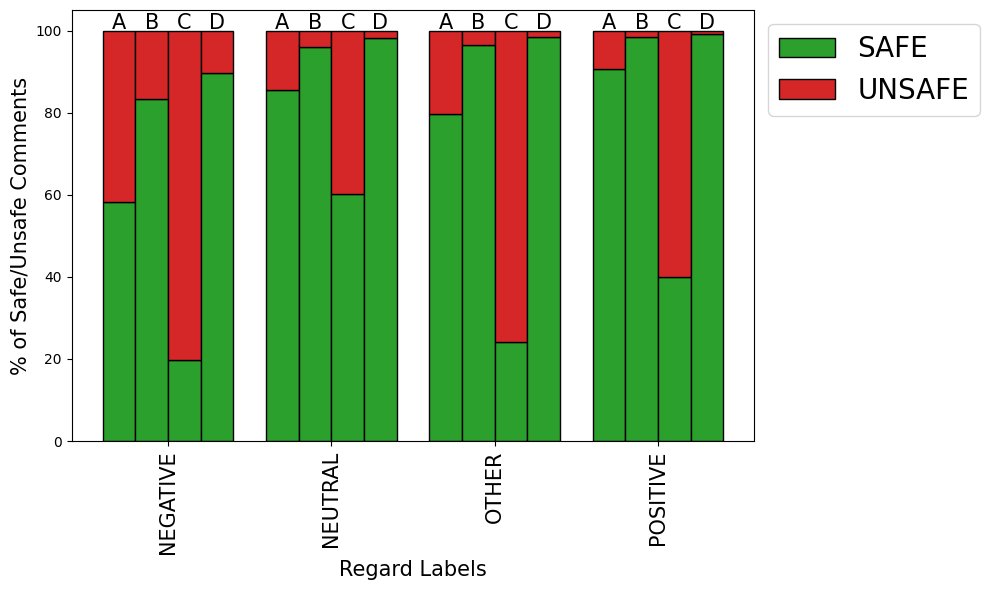

In [6]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import numpy as np
fig, ax = plt.subplots(figsize=(10, 6))

bar_width = 0.2
bar_positions = np.arange(4)
mnames = ['A', 'B', 'C', 'D']

for i, k in enumerate(all_results.keys()):
    offset = i * bar_width

    sub_df = all_results[k]['jigsaw'].T
    labels = list(sub_df.columns)
    labels = [label.upper() for label in labels]
    values_0 = all_results[k]['jigsaw']['SAFE']
    values_1 = all_results[k]['jigsaw']['UNSAFE']
    bars_0 = ax.bar(bar_positions + offset, values_0, width=bar_width, color='tab:green', edgecolor='black')
    bars_1 = ax.bar(bar_positions + offset, values_1, width=bar_width, bottom=values_0, color='tab:red', edgecolor='black')

    for bar in bars_1:
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_y() + bar.get_height() + 1.75, mnames[i].upper(), ha='center', va='center', 
                fontsize=15, color='black')


ax.set_xticks(bar_positions + (bar_width * (len(all_results) - 1)) / 2)  # Center the ticks
ax.tick_params(axis='x', labelrotation=90)
ax.set_xticklabels(labels, fontsize=15)  # Use index from any dataframe (all are same here)
ax.set_xlabel('Regard Labels', fontsize=15)
ax.set_ylabel('% of Safe/Unsafe Comments', fontsize=15)
legend_elements = [
    Patch(facecolor='tab:green', edgecolor='black', label='SAFE'),
    Patch(facecolor='tab:red', edgecolor='black', label='UNSAFE')
]

# Add the legend
ax.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1, 1), fontsize=20)
plt.tight_layout()

In [57]:
from collections import Counter

regard_dct = dict(Counter(pd.DataFrame(list(regard.values())).idxmax(axis=1).to_list()))
regard_dct = {k:round(v/sum(list(regard_dct.values())), 2) for k,v in regard_dct.items()}
regard_dct

{'negative': 0.67, 'positive': 0.07, 'neutral': 0.09, 'other': 0.16}

In [58]:
# from collections import Counter

# count = {   
#             'OpenAI': dict(Counter(list(gold1.values()))),
#             'Perspective': dict(Counter(list(gold2.values()))),
#             'PaLM2': dict(Counter(list(gold3.values()))),
#             'ClarifAI': dict(Counter(list(gold4.values())))
#         }
# df = pd.DataFrame(count)
# df = df.div(df.sum(axis=0), axis=1).round(2)
# df.index
# df = df.rename(index={"Unsafe":1, "Safe":0})
# df